# Overview
A Sample of Frequency Encoding on Bank Data available on https://www.kaggle.com/rouseguy/bankbalanced

# Description of Data

## Input variables:
### bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')

### related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a 
realistic predictive model.

### other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
val init = 1

Intitializing Scala interpreter ...

Spark Web UI available at http://192.168.2.10:4041
SparkContext available as 'sc' (version = 3.0.0, master = local[*], app id = local-1601862307727)
SparkSession available as 'spark'


init: Int = 1


# Load Data

In [2]:
import org.apache.spark.sql.types._
import org.apache.spark.sql.functions._
val schema =StructType(Array(
    StructField("age", IntegerType, false),
    StructField("job", StringType, false),
    StructField("marital", StringType, false),
    StructField("education", StringType, false),
    StructField("default", StringType, false),
    StructField("balance", DoubleType, false),
    StructField("housing", StringType, false),
    StructField("loan", StringType, false),
    StructField("contact", StringType, false),
    StructField("day", IntegerType, false),
    StructField("month", StringType, false),
    StructField("duration", IntegerType, false),
    StructField("campaign", IntegerType, false),
    StructField("pdays", IntegerType, false),
    StructField("previous", IntegerType, false),
    StructField("poutcome", StringType, false),
    StructField("deposit", StringType, false)
))
val raw = spark.read.format("csv")
    .option("header","true")
    .schema(schema)
    .load("bank.csv")
raw.show(10)

+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.| married|secondary|     no| 2343.0|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.| married|secondary|     no|   45.0|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician| married|secondary|     no| 1270.0|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services| married|secondary|     no| 2476.0|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.| married| tertiary|     no|  184.0|     no|  no|unkno

import org.apache.spark.sql.types._
import org.apache.spark.sql.functions._
schema: org.apache.spark.sql.types.StructType = StructType(StructField(age,IntegerType,false), StructField(job,StringType,false), StructField(marital,StringType,false), StructField(education,StringType,false), StructField(default,StringType,false), StructField(balance,DoubleType,false), StructField(housing,StringType,false), StructField(loan,StringType,false), StructField(contact,StringType,false), StructField(day,IntegerType,false), StructField(month,StringType,false), StructField(duration,IntegerType,false), StructField(campaign,IntegerType,false), StructField(pdays,IntegerType,false), StructField(previous,IntegerType,false), StructField(poutcome,StringType,false), StructField(deposit,StringType,false))
raw: o...


Lets convert some categorical yes no variable to 0 1
This is part of feature engineering but we are starting with the basics

In [3]:
val data = raw.withColumn("default",when($"default" === "yes",1).otherwise(0))
    .withColumn("housing",when($"housing" === "yes",1).otherwise(0))
    .withColumn("loan",when($"loan" === "yes",1).otherwise(0))
    .withColumn("month", 
        when($"month" === "jan",1)
        .when($"month" === "feb",2)
        .when($"month" === "mar",3)
        .when($"month" === "apr",4)
        .when($"month" === "may",5)
        .when($"month" === "jun",6)
        .when($"month" === "jul",7)
        .when($"month" === "aug",8)
        .when($"month" === "sep",9)
        .when($"month" === "oct",10)
        .when($"month" === "nov",11)
        .when($"month" === "dec",12))
    .withColumn("deposit",when($"deposit" === "yes",1).otherwise(0))
    
data.show(10)

+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.| married|secondary|      0| 2343.0|      1|   0|unknown|  5|    5|    1042|       1|   -1|       0| unknown|      1|
| 56|    admin.| married|secondary|      0|   45.0|      0|   0|unknown|  5|    5|    1467|       1|   -1|       0| unknown|      1|
| 41|technician| married|secondary|      0| 1270.0|      1|   0|unknown|  5|    5|    1389|       1|   -1|       0| unknown|      1|
| 55|  services| married|secondary|      0| 2476.0|      1|   0|unknown|  5|    5|     579|       1|   -1|       0| unknown|      1|
| 54|    admin.| married| tertiary|      0|  184.0|      0|   0|unkno

data: org.apache.spark.sql.DataFrame = [age: int, job: string ... 15 more fields]


In [4]:
data.createOrReplaceTempView("data")

# Exploratory Analysis

In the next cells we are going to switch between scala and python. Usually python wil be used data plotting.

Most of the comparisons are between one dimension and balance and deposit.

I did not choose any special technique.

I also did not take into day and month variables due that these are time series. In future I'm going to build a test for time series analysis.

In [5]:
%%python
import databricks.koalas as ks
import tempfile
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image

ks.set_option("plotting.max_rows", 1000000)
data = spark.table("data").to_koalas()

print(data.head(5))

   age         job  marital  education  default  balance  housing  loan  contact  day  month  duration  campaign  pdays  previous poutcome  deposit
0   59      admin.  married  secondary        0   2343.0        1     0  unknown    5      5      1042         1     -1         0  unknown        1
1   56      admin.  married  secondary        0     45.0        0     0  unknown    5      5      1467         1     -1         0  unknown        1
2   41  technician  married  secondary        0   1270.0        1     0  unknown    5      5      1389         1     -1         0  unknown        1
3   55    services  married  secondary        0   2476.0        1     0  unknown    5      5       579         1     -1         0  unknown        1
4   54      admin.  married   tertiary        0    184.0        0     0  unknown    5      5       673         2     -1         0  unknown        1


## Numerical Variables

In [6]:
data.select("age","balance","day","duration","campaign","pdays","previous").summary().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|           balance|               day|          duration|          campaign|             pdays|          previous|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             11162|             11162|             11162|             11162|             11162|             11162|             11162|
|   mean|41.231947679627304|1528.5385235620856|15.658036194230425|371.99381831213043| 2.508421429851281| 51.33040673714388|0.8325568894463358|
| stddev|11.913369192215518| 3225.413325946149| 8.420739541006462|347.12838571630687|2.7220771816614824|108.75828197197717| 2.292007218670508|
|    min|                18|           -6847.0|                 1|                 2|                 1|                -1|                 0|

## Age 

In [7]:
data.groupBy("age").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+---+-----+----------+
|age|count|percentage|
+---+-----+----------+
| 31|  496|       4.4|
| 32|  477|       4.3|
| 34|  466|       4.2|
| 33|  464|       4.2|
| 35|  461|       4.1|
| 30|  456|       4.1|
| 36|  432|       3.9|
| 37|  370|       3.3|
| 38|  353|       3.2|
| 39|  343|       3.1|
| 29|  328|       2.9|
| 40|  326|       2.9|
| 41|  299|       2.7|
| 42|  295|       2.6|
| 28|  292|       2.6|
| 46|  258|       2.3|
| 47|  255|       2.3|
| 45|  253|       2.3|
| 43|  249|       2.2|
| 27|  246|       2.2|
+---+-----+----------+
only showing top 20 rows



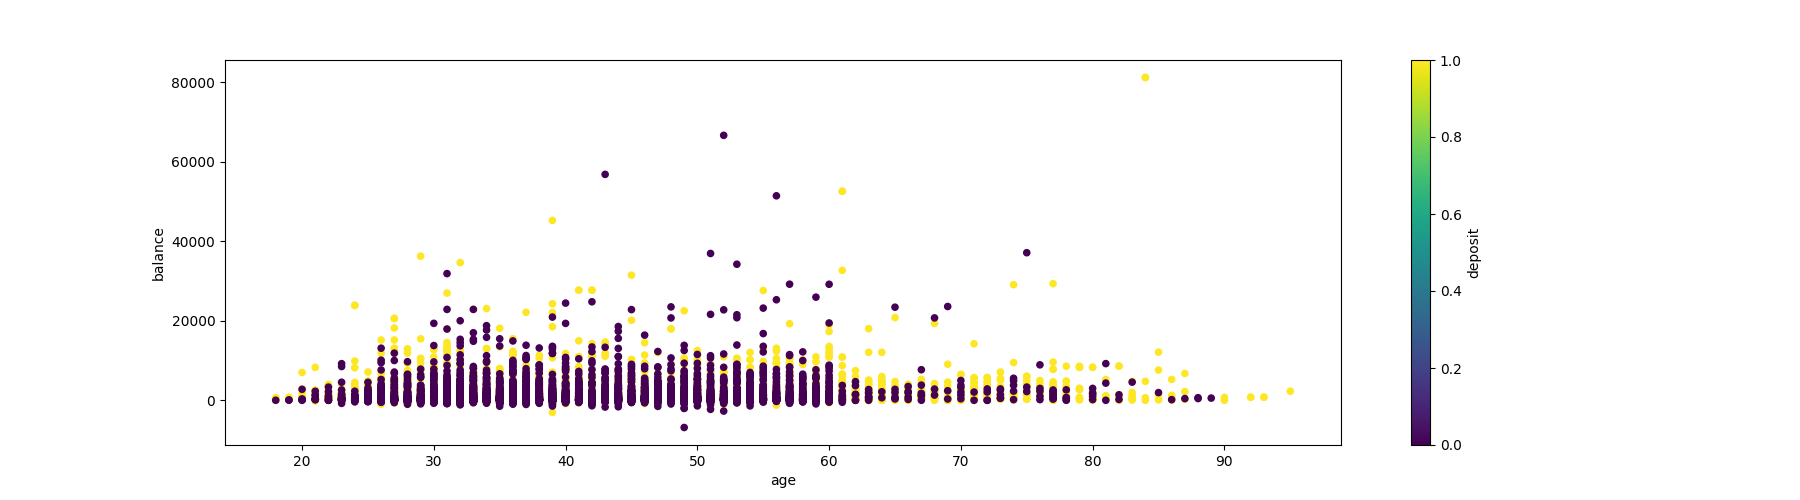

In [8]:
%%python

plt.rcParams['figure.figsize'] = [18, 5]
data.plot.scatter(x='age',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Job

In [9]:
data.groupBy("job").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+-------------+-----+----------+
|          job|count|percentage|
+-------------+-----+----------+
|   management| 2566|      23.0|
|  blue-collar| 1944|      17.4|
|   technician| 1823|      16.3|
|       admin.| 1334|      12.0|
|     services|  923|       8.3|
|      retired|  778|       7.0|
|self-employed|  405|       3.6|
|      student|  360|       3.2|
|   unemployed|  357|       3.2|
| entrepreneur|  328|       2.9|
|    housemaid|  274|       2.5|
|      unknown|   70|       0.6|
+-------------+-----+----------+



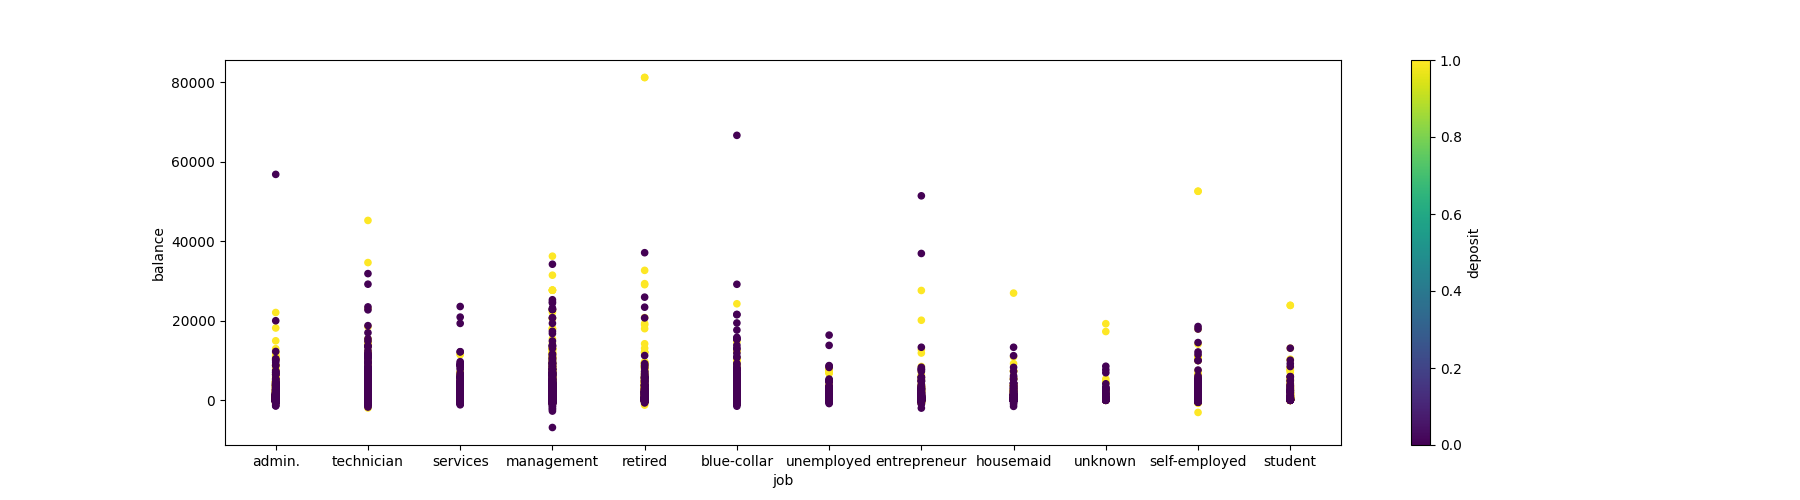

In [10]:
%%python

plt.rcParams['figure.figsize'] = [18, 5]
data.plot.scatter(x='job',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Marital

In [11]:
data.groupBy("marital").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+--------+-----+----------+
| marital|count|percentage|
+--------+-----+----------+
| married| 6351|      56.9|
|  single| 3518|      31.5|
|divorced| 1293|      11.6|
+--------+-----+----------+



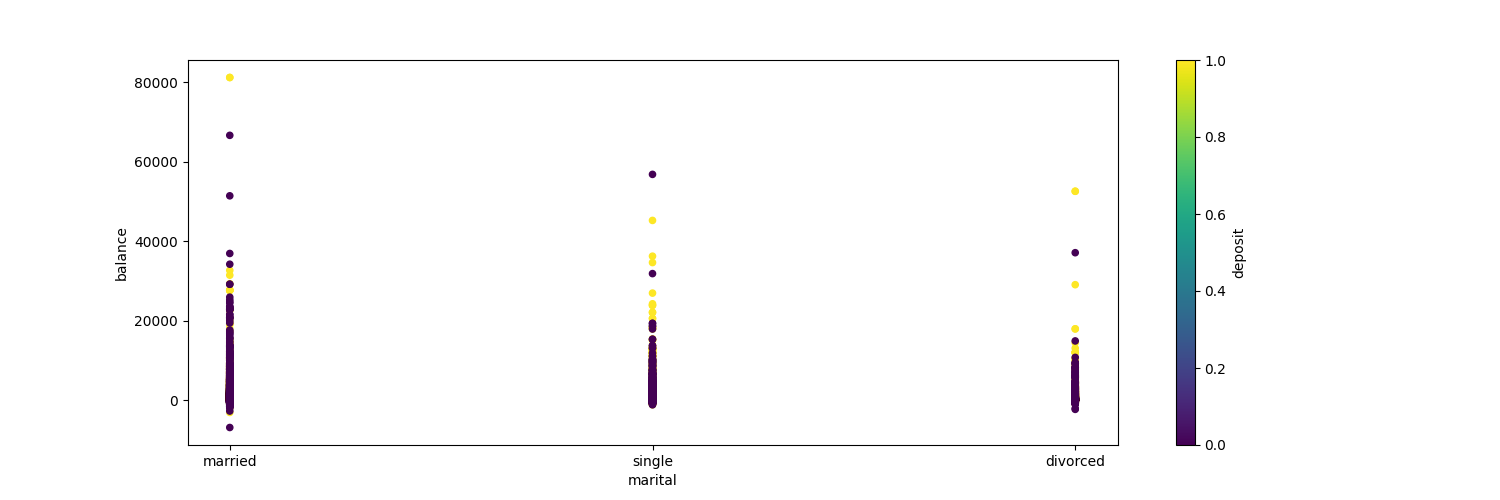

In [12]:
%%python

plt.rcParams['figure.figsize'] = [15, 5]
data.plot.scatter(x='marital',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Education

In [13]:
data.groupBy("education").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+---------+-----+----------+
|education|count|percentage|
+---------+-----+----------+
|secondary| 5476|      49.1|
| tertiary| 3689|      33.0|
|  primary| 1500|      13.4|
|  unknown|  497|       4.5|
+---------+-----+----------+



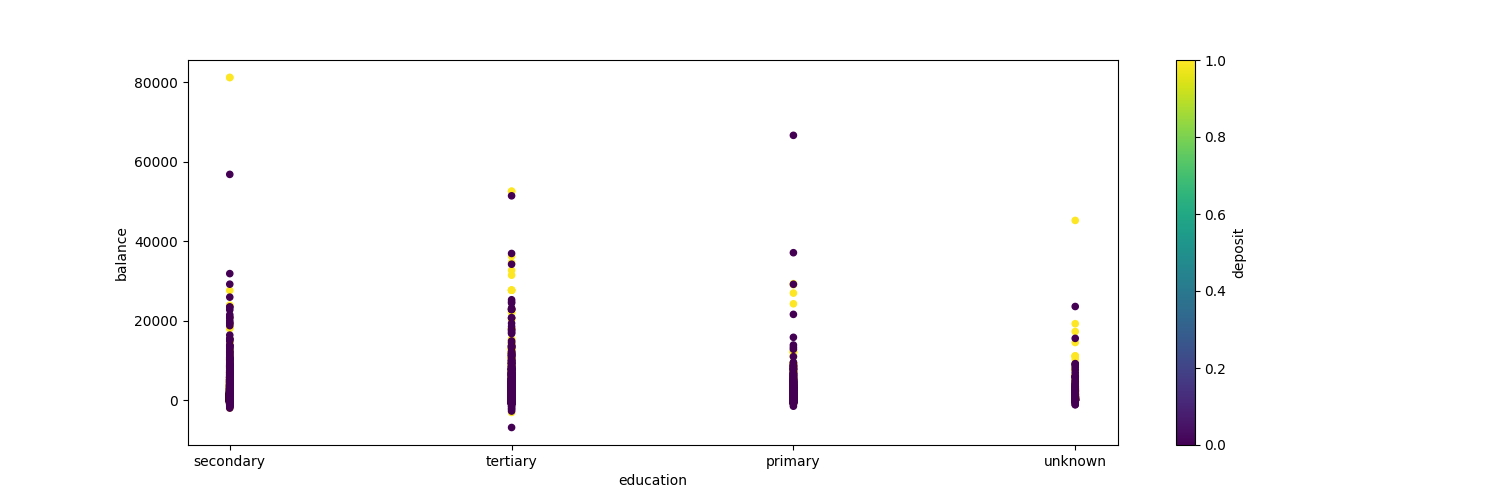

In [14]:
%%python

plt.rcParams['figure.figsize'] = [15, 5]
data.plot.scatter(x='education',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Default

In [15]:
data.groupBy("default").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+-------+-----+----------+
|default|count|percentage|
+-------+-----+----------+
|      0|10994|      98.5|
|      1|  168|       1.5|
+-------+-----+----------+



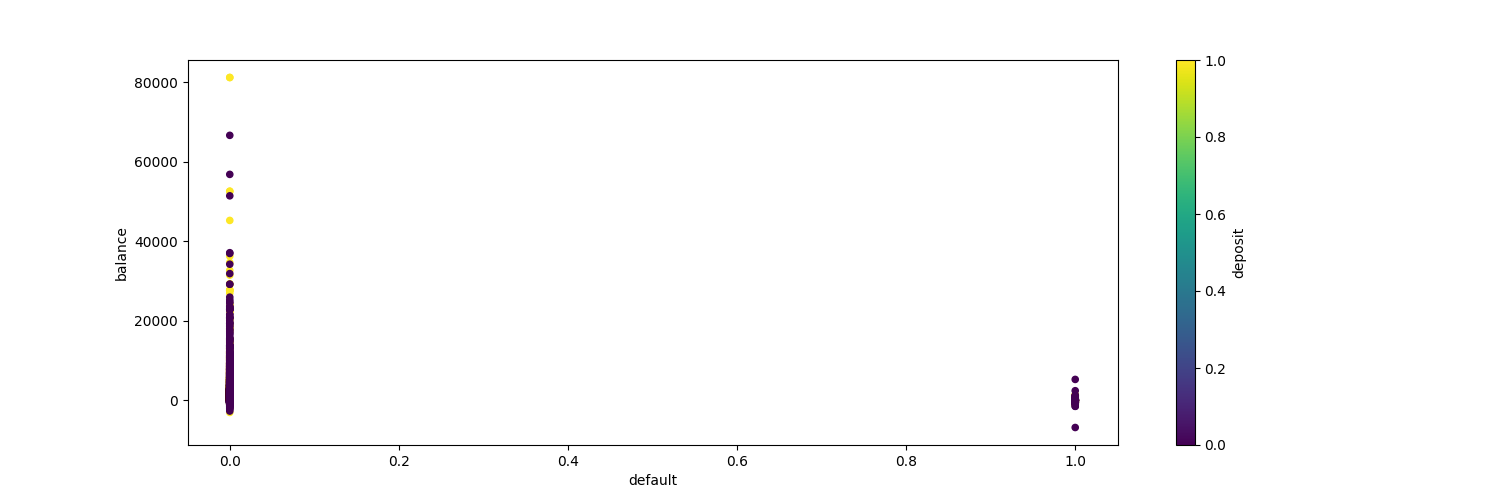

In [16]:
%%python

plt.rcParams['figure.figsize'] = [15, 5]
data.plot.scatter(x='default',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Housing

In [17]:
data.groupBy("housing").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+-------+-----+----------+
|housing|count|percentage|
+-------+-----+----------+
|      0| 5881|      52.7|
|      1| 5281|      47.3|
+-------+-----+----------+



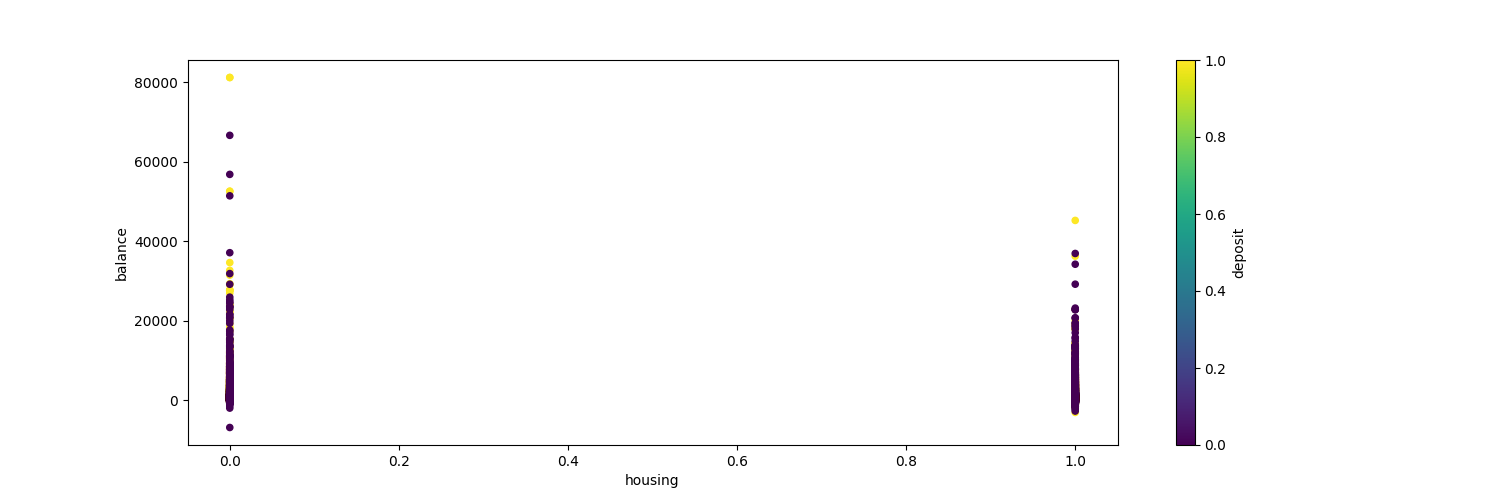

In [18]:
%%python

plt.rcParams['figure.figsize'] = [15, 5]
data.plot.scatter(x='housing',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Loan

In [19]:
data.groupBy("loan").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+----+-----+----------+
|loan|count|percentage|
+----+-----+----------+
|   0| 9702|      86.9|
|   1| 1460|      13.1|
+----+-----+----------+



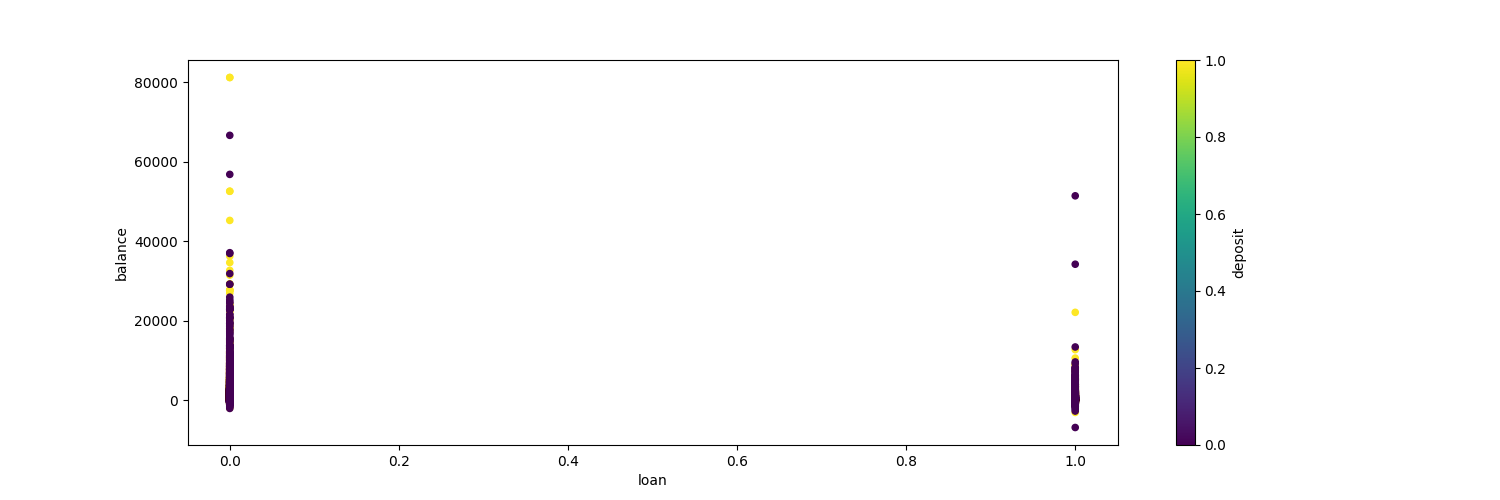

In [20]:
%%python

plt.rcParams['figure.figsize'] = [15, 5]
data.plot.scatter(x='loan',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Contact

In [21]:
data.groupBy("contact").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+---------+-----+----------+
|  contact|count|percentage|
+---------+-----+----------+
| cellular| 8042|      72.0|
|  unknown| 2346|      21.0|
|telephone|  774|       6.9|
+---------+-----+----------+



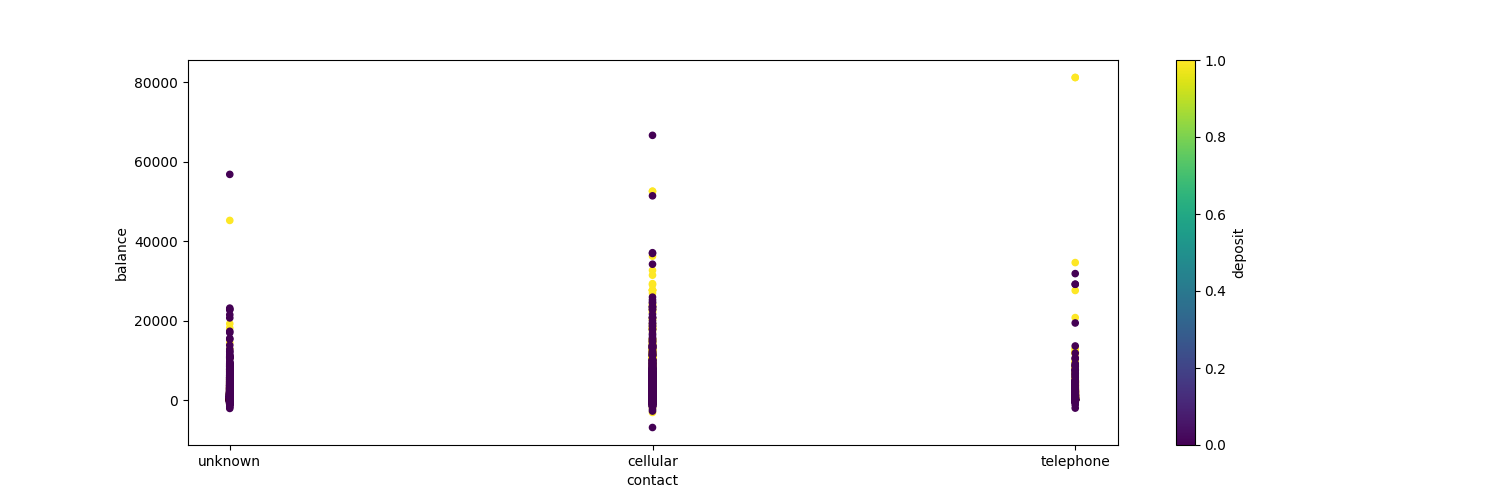

In [22]:
%%python

plt.rcParams['figure.figsize'] = [15, 5]
data.plot.scatter(x='contact',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Duration

In [23]:
data.groupBy("duration").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+--------+-----+----------+
|duration|count|percentage|
+--------+-----+----------+
|      97|   39|       0.3|
|     161|   38|       0.3|
|     150|   37|       0.3|
|     158|   37|       0.3|
|     119|   37|       0.3|
|     144|   36|       0.3|
|     114|   36|       0.3|
|     112|   35|       0.3|
|     136|   35|       0.3|
|     131|   35|       0.3|
|      90|   35|       0.3|
|     135|   34|       0.3|
|     152|   33|       0.3|
|     139|   33|       0.3|
|     185|   33|       0.3|
|     101|   33|       0.3|
|     126|   33|       0.3|
|      85|   32|       0.3|
|     173|   32|       0.3|
|     193|   32|       0.3|
+--------+-----+----------+
only showing top 20 rows



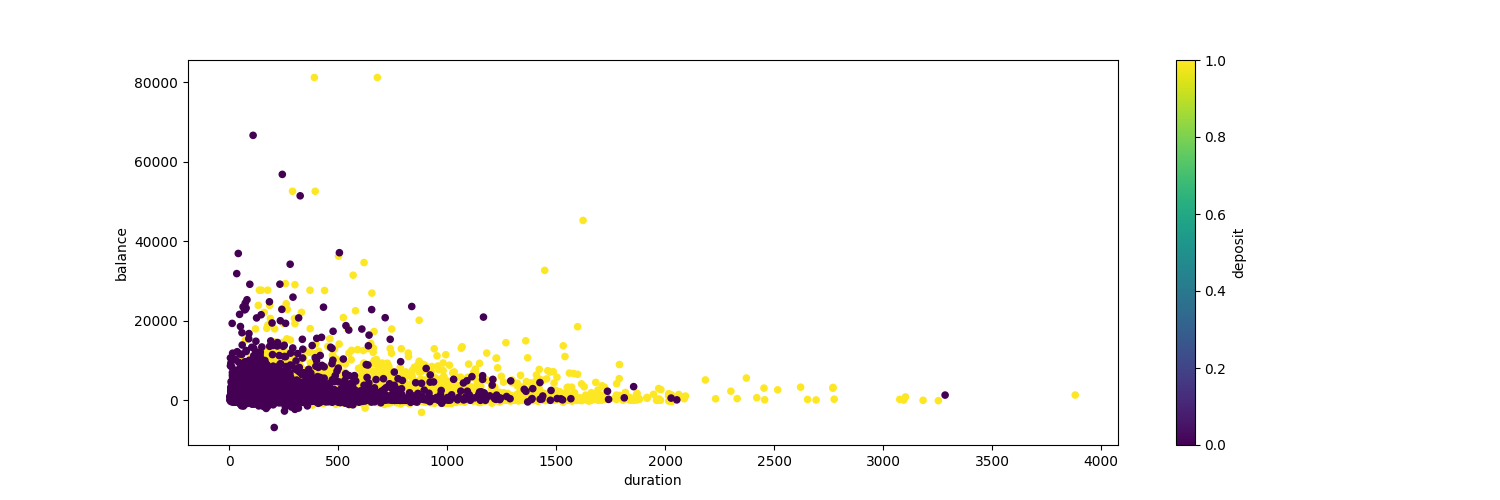

In [24]:
%%python

plt.rcParams['figure.figsize'] = [15, 5]
data.plot.scatter(x='duration',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Campaign

In [25]:
data.groupBy("campaign").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+--------+-----+----------+
|campaign|count|percentage|
+--------+-----+----------+
|       1| 4798|      43.0|
|       2| 3028|      27.1|
|       3| 1321|      11.8|
|       4|  771|       6.9|
|       5|  378|       3.4|
|       6|  265|       2.4|
|       7|  139|       1.2|
|       8|  128|       1.1|
|       9|   72|       0.6|
|      10|   52|       0.5|
|      11|   40|       0.4|
|      13|   30|       0.3|
|      12|   29|       0.3|
|      14|   15|       0.1|
|      17|   14|       0.1|
|      15|   13|       0.1|
|      16|    9|       0.1|
|      21|    8|       0.1|
|      18|    8|       0.1|
|      20|    5|       0.0|
+--------+-----+----------+
only showing top 20 rows



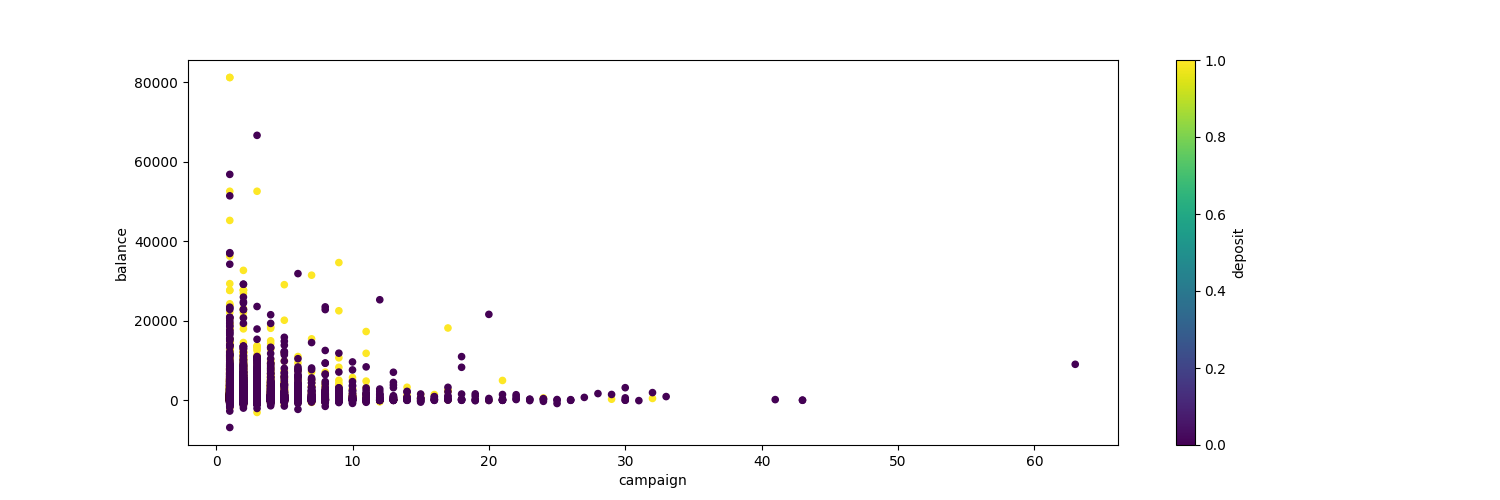

In [26]:
%%python

plt.rcParams['figure.figsize'] = [15, 5]
data.plot.scatter(x='campaign',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Pdays

In [27]:
data.groupBy("pdays").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+-----+-----+----------+
|pdays|count|percentage|
+-----+-----+----------+
|   -1| 8324|      74.6|
|   92|  106|       0.9|
|  182|   89|       0.8|
|   91|   84|       0.8|
|  181|   81|       0.7|
|  183|   73|       0.7|
|  184|   52|       0.5|
|   94|   42|       0.4|
|   93|   41|       0.4|
|   95|   39|       0.3|
|   87|   34|       0.3|
|   90|   32|       0.3|
|   98|   31|       0.3|
|  185|   30|       0.3|
|  187|   28|       0.3|
|   96|   26|       0.2|
|   97|   26|       0.2|
|  189|   24|       0.2|
|  188|   24|       0.2|
|  105|   22|       0.2|
+-----+-----+----------+
only showing top 20 rows



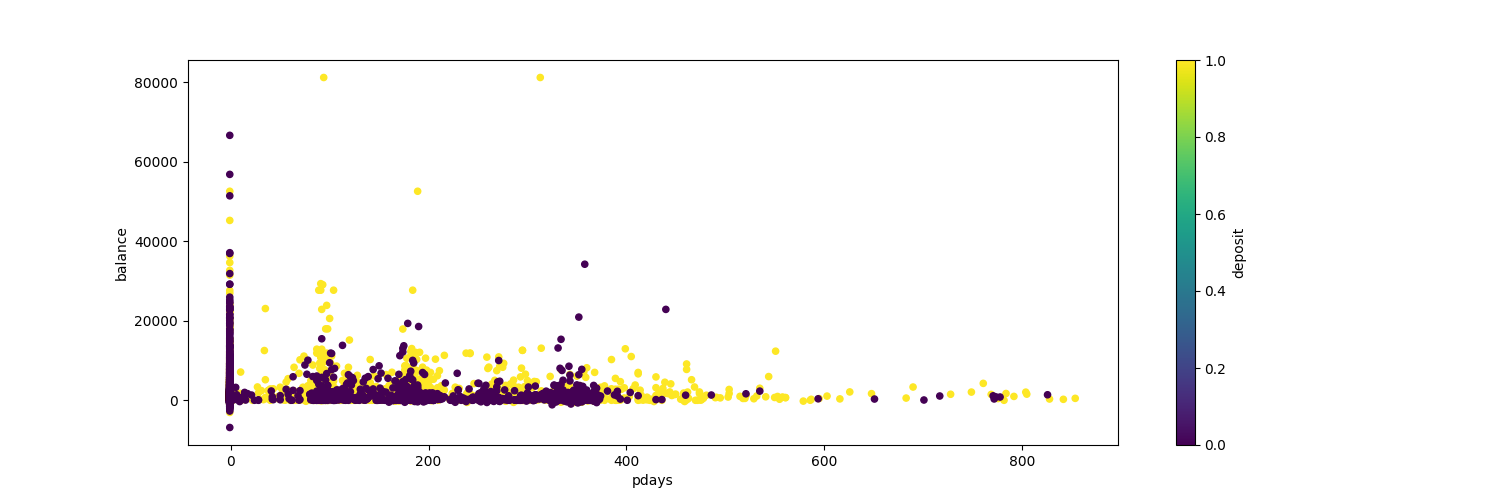

In [28]:
%%python

plt.rcParams['figure.figsize'] = [15, 5]
data.plot.scatter(x='pdays',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Previous

In [29]:
data.groupBy("previous").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+--------+-----+----------+
|previous|count|percentage|
+--------+-----+----------+
|       0| 8324|      74.6|
|       1|  887|       7.9|
|       2|  693|       6.2|
|       3|  435|       3.9|
|       4|  244|       2.2|
|       5|  165|       1.5|
|       6|  117|       1.0|
|       7|   77|       0.7|
|       8|   60|       0.5|
|       9|   34|       0.3|
|      10|   30|       0.3|
|      11|   23|       0.2|
|      12|   16|       0.1|
|      17|   11|       0.1|
|      13|   11|       0.1|
|      14|    6|       0.1|
|      15|    5|       0.0|
|      19|    4|       0.0|
|      27|    2|       0.0|
|      16|    2|       0.0|
+--------+-----+----------+
only showing top 20 rows



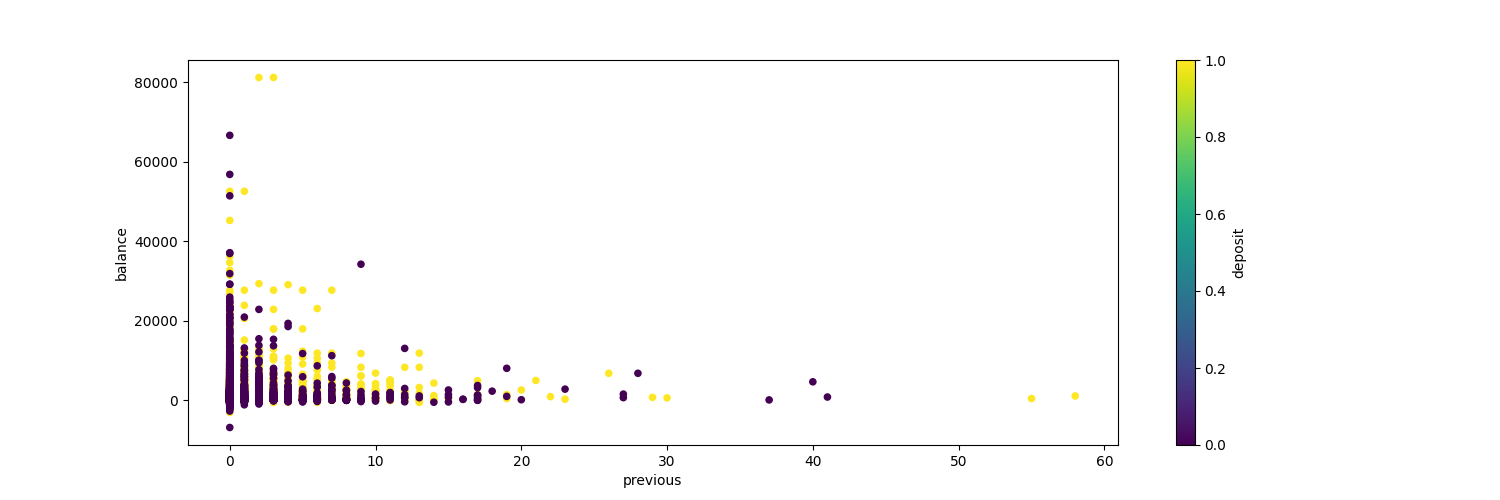

In [30]:
%%python

plt.rcParams['figure.figsize'] = [15, 5]
data.plot.scatter(x='previous',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Poutcome

In [31]:
data.groupBy("poutcome").count()
    .withColumn("percentage", round(col("count") * 100 /  sum("count").over(),1))
    .orderBy(desc("count"))
    .show()

+--------+-----+----------+
|poutcome|count|percentage|
+--------+-----+----------+
| unknown| 8326|      74.6|
| failure| 1228|      11.0|
| success| 1071|       9.6|
|   other|  537|       4.8|
+--------+-----+----------+



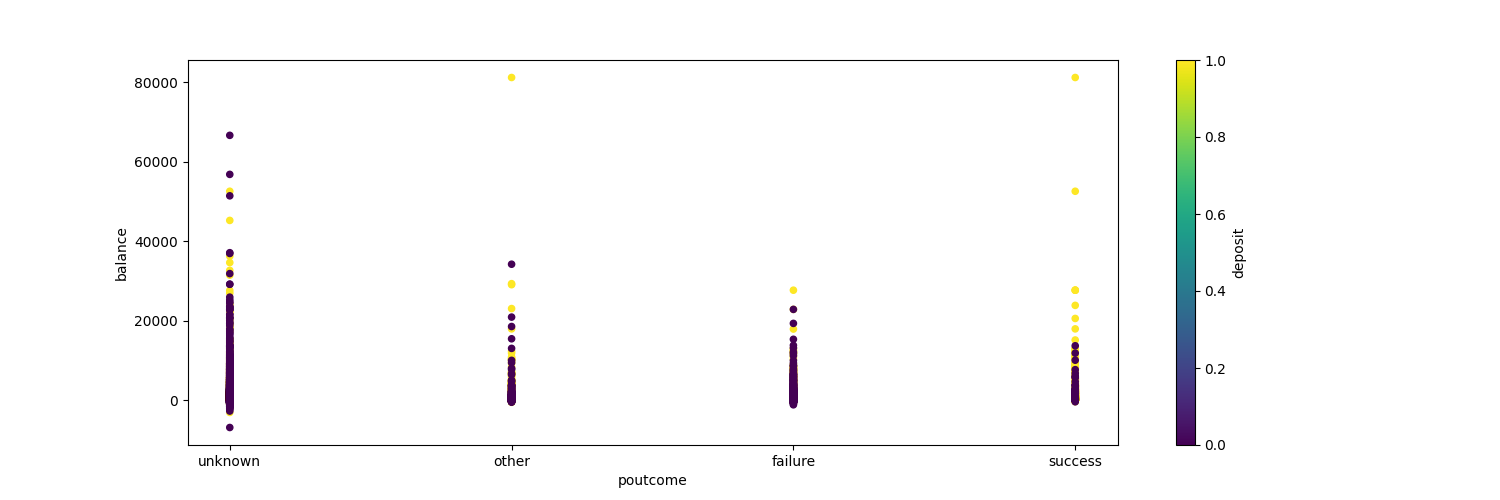

In [32]:
%%python

plt.rcParams['figure.figsize'] = [15, 5]
data.plot.scatter(x='poutcome',y='balance',c="deposit",colormap='viridis')

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

# Feature Engineering for Some Categorial Variables

We are going to apply Frequency Encoding for almost all variables.

At the end we are going to plot a correclation matrix

In [33]:
val job_codes = data.groupBy("job").count
    .orderBy("count")
    .withColumnRenamed("count","job_count")
job_codes.show()

+-------------+---------+
|          job|job_count|
+-------------+---------+
|      unknown|       70|
|    housemaid|      274|
| entrepreneur|      328|
|   unemployed|      357|
|      student|      360|
|self-employed|      405|
|      retired|      778|
|     services|      923|
|       admin.|     1334|
|   technician|     1823|
|  blue-collar|     1944|
|   management|     2566|
+-------------+---------+



job_codes: org.apache.spark.sql.DataFrame = [job: string, job_count: bigint]


In [34]:
val marital_codes = data.groupBy("marital").count
    .orderBy("count")
    .withColumnRenamed("count","marital_count")
marital_codes.show()

+--------+-------------+
| marital|marital_count|
+--------+-------------+
|divorced|         1293|
|  single|         3518|
| married|         6351|
+--------+-------------+



marital_codes: org.apache.spark.sql.DataFrame = [marital: string, marital_count: bigint]


In [35]:
val education_codes = data.groupBy("education").count
    .orderBy("count")
    .withColumnRenamed("count","education_count")
education_codes.show()

+---------+---------------+
|education|education_count|
+---------+---------------+
|  unknown|            497|
|  primary|           1500|
| tertiary|           3689|
|secondary|           5476|
+---------+---------------+



education_codes: org.apache.spark.sql.DataFrame = [education: string, education_count: bigint]


In [36]:
val contact_codes = data.groupBy("contact").count
    .orderBy("count")
    .withColumnRenamed("count","contact_count")
contact_codes.show()

+---------+-------------+
|  contact|contact_count|
+---------+-------------+
|telephone|          774|
|  unknown|         2346|
| cellular|         8042|
+---------+-------------+



contact_codes: org.apache.spark.sql.DataFrame = [contact: string, contact_count: bigint]


In [37]:
val poutcome_codes = data.groupBy("poutcome").count
    .orderBy("count")
    .withColumnRenamed("count","poutcome_count")
poutcome_codes.show()

+--------+--------------+
|poutcome|poutcome_count|
+--------+--------------+
|   other|           537|
| success|          1071|
| failure|          1228|
| unknown|          8326|
+--------+--------------+



poutcome_codes: org.apache.spark.sql.DataFrame = [poutcome: string, poutcome_count: bigint]


In [38]:
val datav2 = data
    .join(job_codes,Seq("job"))
    .join(marital_codes,Seq("marital"))
    .join(education_codes,Seq("education"))
    .join(contact_codes,Seq("contact"))
    .join(poutcome_codes,Seq("poutcome"))

datav2.createOrReplaceTempView("datav2")
datav2.show(10)

+--------+-------+---------+--------+----------+---+-------+-------+-------+----+---+-----+--------+--------+-----+--------+-------+---------+-------------+---------------+-------------+--------------+
|poutcome|contact|education| marital|       job|age|default|balance|housing|loan|day|month|duration|campaign|pdays|previous|deposit|job_count|marital_count|education_count|contact_count|poutcome_count|
+--------+-------+---------+--------+----------+---+-------+-------+-------+----+---+-----+--------+--------+-----+--------+-------+---------+-------------+---------------+-------------+--------------+
| unknown|unknown|secondary| married|    admin.| 59|      0| 2343.0|      1|   0|  5|    5|    1042|       1|   -1|       0|      1|     1334|         6351|           5476|         2346|          8326|
| unknown|unknown|secondary| married|    admin.| 56|      0|   45.0|      0|   0|  5|    5|    1467|       1|   -1|       0|      1|     1334|         6351|           5476|         2346|      

datav2: org.apache.spark.sql.DataFrame = [poutcome: string, contact: string ... 20 more fields]


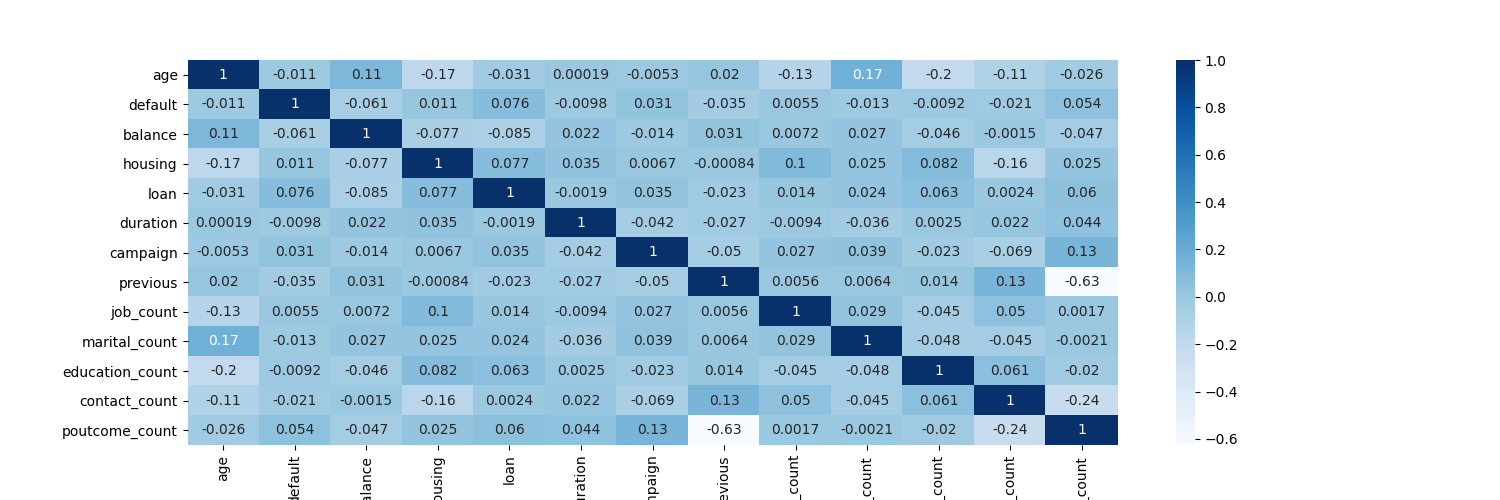

In [39]:
%%python

plt.clf()

# pday is excluded
columns = ["age","default","balance","housing","loan","duration","campaign","previous","job_count","marital_count","education_count","contact_count","poutcome_count"]

corr_values = spark.table("datav2").to_koalas()[columns].corr().to_numpy()

sns.heatmap(corr_values, cmap='Blues', annot = True, square = False,
            xticklabels=columns,yticklabels=columns)

with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)